## Preliminary version of an API to integrate TVB with the EBRAINS KG using `siibra-python`.
### Focuses on retrieving and creating TVB Structural and Functional Connectivities
##### <font color='red'>Note: For the API to work, an EBRAINS authentication token needs to be set or the API should be used in an EBRAINS environment.</font>

### Imports and setup

In [1]:
import os
import numpy as np
import siibra
from tvb.simulator.lab import *

[siibra:INFO] Version: 0.3a24
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


In [2]:
LOG = get_logger()

In [45]:
# Add an EBRAINS token
os.environ['HBP_AUTH_TOKEN'] = ''

### Create API

#### Utility functions for both structural and functional connectivities

In [4]:
def check_atlas_parcellation_compatible(atlas, parcellation):
    """ Given an atlas and a parcellation, verify that the atlas contains the parcellation, i.e. they are compatible """
    return parcellation in list(atlas.parcellations)

In [5]:
def get_atlases_for_parcellation(parcelation):
    """ Given a parcelation, return all the atlases that contain it """
    return list(parcelation.atlases)

In [6]:
def get_parcellations_for_atlas(atlas):
    """ Given the name of an atlas, return all the parcellations inside it """
    return list(atlas.parcellations)

In [21]:
def init_siibra_params(atlas_name, parcellation_name, subject_ids):
    
    atlas = siibra.atlases[atlas_name] if atlas_name else None
    parcellation = siibra.parcellations[parcellation_name] if parcellation_name else None
    
    
    if atlas and parcellation:
        compatible = check_atlas_parcellation_compatible(atlas, parcellation)
        if not compatible:
            LOG.error(f'Atlas {atlas.name} does not contain parcellation {parcellation.name}. Please choose a different atlas and/or parcellation')
            print(f'Atlas {atlas.name} does not contain parcellation {parcellation.name}. Please choose a different atlas and/or parcellation')
            return
        
    if atlas and not parcellation:
        LOG.warning(f'No parcellation was provided, so a default one will be selected.')
        print(f'No parcellation was provided, so a default one will be selected.')
        parcellations = get_parcellations_for_atlas(atlas)
        no_parcellations = len(parcellations)
        if no_parcellations < 1:
            LOG.error(f'No default parcellation was found for atlas {atlas.name}!')
            print(f'No default parcellation was found for atlas {atlas.name}!')
            return
        if no_parcellations > 1:
            LOG.info(f'Multiple parcellaation were founded for atlas {atlas.name}. An arbitrary one will be selected.')
            print(f'Multiple parcellaation were founded for atlas {atlas.name}. An arbitrary one will be selected.')
        parcellation = parcellations[0]
        
    if not atlas and parcellation:
        LOG.warning('A parcellation was provided without an atlas, so a default atlas will be selected.')
        print('A parcellation was provided without an atlas, so a default atlas will be selected.')
        atlases = get_atlases_for_parcellation(parcellation)
        no_atlases = len(atlases)
        if no_atlases < 1:
            LOG.error(f'No default atlas containing parcellation {parcellation.name} was found!')
            print(f'No default atlas containing parcellation {parcellation.name} was found!')
            return
        if no_atlases > 1:
            LOG.info(f'Multiple atlases containing parcellation {parcellation_name} were found. An aribitrary one will be selected')
            print(f'Multiple atlases containing parcellation {parcellation_name} were found. An aribitrary one will be selected')
        atlas = atlases[0]
        
    if not atlas and not parcellation:
        LOG.warning(f'No atlas and no parcellation were provided, so default ones will be selected.')
        print(f'No atlas and no parcellation were provided, so default ones will be selected.')
        atlas = siibra.atlases[DEFAULT_ATLAS]
        parcellation = siibra.parcellations[DEFAULT_PARCELLATION]
    
    LOG.info(f'Using atlas {atlas.name} and parcellation {parcellation.name}')
    print(f'Using atlas {atlas.name} and parcellation {parcellation.name}')
    
    if subject_ids == 'all':
        LOG.info(f'No list of subject ids was provided, so the connectivities will be computed for all available subjects!')
        (f'No list of subject ids was provided, so the connectivities will be computed for all available subjects!')
    
    # return get_connectivities_using_siibra(atlas, parcellation, subject_ids)
    return atlas, parcellation, subject_ids

In [28]:
def get_connectivity_component(parcellation, component):
    """ Return a list of all available connectivity components (weights/tract lengths) """
    modality = None
    if component == 'weights':
        modality = siibra.modalities.StreamlineCounts
    if component == 'tracts':
        modality = siibra.modalities.StreamlineLengths
    if component == 'fc':
        modality = siibra.modalities.FunctionalConnectivity
        
    all_conns = siibra.get_features(parcellation, modality)
    
    if len(all_conns) == 0:
        LOG.error(f'No connectivity {component} were found in parcellation {parcellation}!')
        return None
    
    return all_conns

In [10]:
def get_hemispheres_for_regions(region_names):
    """ Given a list of region names, compute the hemispheres to which they belon to """
    LOG.info(f'Computing hemispheres for regions')
    hemi = []
    for name in region_names:
        if 'right' in name:
            hemi.append(1)
        # TODO: regions refering to both hemispheres are put in the left hemisphere; change this?
        else:
            hemi.append(0) 
            
    return hemi

In [12]:
def get_regions_positions(regions):
    """ Given a list of regions, compute the positions of their centroids """
    LOG.info(f'Computing positions for regions')
    positions = []
    
    # get the parcellation of these regions to retrieve a compatible space
    parcellation = regions[0].parcellation
    space = siibra.spaces.MNI152_2009C_NONL_ASYM # commonly used space in other examples
    
    for r in regions:
        # get centroids list
        centroids = r.centroids(space)
        # get siibra.Point object from centroid list; some regions have multiple centroids, but only the first one is selected
        centroids = centroids[0]
        # tuple() gives the coordinates of a centroid
        positions.append(tuple(centroids))
        
    return positions

In [13]:
def create_tvb_connectivity(weights_matrix, tracts_matrix, region_names, hemispheres, positions):
    """ Compute a TVB Connectivity based on its components obtained from siibra """   

    conn = connectivity.Connectivity()
    conn.weights = weights_matrix.to_numpy()
    conn.tract_lengths = tracts_matrix.to_numpy()
    conn.region_labels = np.array(region_names)
    conn.hemispheres = np.array(hemispheres, dtype=np.bool_)
    conn.centres = np.array(positions)

    conn.configure()
    return conn

#### Structural connectivity specific functions

In [9]:
def check_weight_tract_compatibility(weight, tract):
    """ Given a connectivity weight component and a connectivity tract component, check that they both come from the same source """

    weights_info = weight.src_info
    tracts_info = tract.src_info
    
    # TODO: are there any better checks?
    if (len(weight.matrix) != len(tract.matrix) or
        weights_info['name'] != tracts_info['name'] or
        weights_info['dataset_id'] != tracts_info['dataset_id'] or
        weights_info['subject'] != tracts_info['subject']):
        return False
    
    return True

In [43]:
def filter_structural_connectivity_by_id(weights, tracts, subj_ids):
    """ Given two lists of connectivity weights and tract lengths and a list of subject ids, keep only the weights and tracts for those subjects """
    filtered_weights = []
    filtered_tracts = []
    
    for subj in subj_ids:
        weight = [w for w in weights if w.subject == subj]
        tract = [t for t in tracts if t.subject == subj]
        
        filtered_weights += weight
        filtered_tracts += tract
            
    return filtered_weights, filtered_tracts

In [44]:
# TODO: is the atlas really needed here?
def get_structural_connectivities_from_kg(atlas=None, parcellation=None, subject_ids='all'):
    """ Return a list of TVB Structural Connectivities, based on the specified atlas and parcellation, for the subjects mentioned in 'subject_ids' """
    atlas, parcellation, subject_ids = init_siibra_params(atlas, parcellation, subject_ids)
    connectivities = []
    weights = get_connectivity_component(parcellation, 'weights')
    tracts = get_connectivity_component(parcellation, 'tracts')
    
    if not weights or not tracts:
        LOG.error(f'Could not find both weights and tract lengths from parcellation {parcellation.name}, so a connectivity cannot be computed')
        return
    
    if not 'all' in subject_ids:
        weights, tracts = filter_structural_connectivity_by_id(weights, tracts, subject_ids)
    
    # so they can be computed only once
    regions = weights[0].matrix.index.values
    region_names = [r.name for r in regions]
    hemi = get_hemispheres_for_regions(region_names)
    positions = get_regions_positions(regions)
    
    LOG.info(f'Computing TVB Connectivities')
    no_conns = min(len(weights), len(tracts)) # in siibra v0.3a24 weights have additional subjects
    for i in range(no_conns):
        weights_matrix = weights[i].matrix
        tracts_matrix = tracts[i].matrix
        conn = create_tvb_connectivity(weights_matrix, tracts_matrix, region_names, hemi, positions)
        connectivities.append(conn)
        
    return connectivities

#### Functional connectivity specific functions

In [41]:
def filter_functional_connectivity_by_id(fcs, subj_ids):
    """ Given a list of functional connectivities and a list of subject ids, keep only the functional connectivities for those subjects """
    filtered_fcs = []
    
    for subj in subj_ids:
        fc = [f for f in fcs if f.subject == subj]
        filtered_fcs += fc
            
    return filtered_fcs

In [39]:
def get_functional_connectivities_from_kg(atlas=None, parcellation=None, subject_ids='all'):
    atlas, parcellation, subject_ids = init_siibra_params(atlas, parcellation, subject_ids)
    connectivities = []
    tvb_fcs = []
    
    fcs = get_connectivity_component(parcellation, 'fc')
    
    if not fcs:
        LOG.error(f'Could not find any functional connectivity in parcellation {parcellation.name}, so a TVB Functional Connectivity cannot be computed')
        return
    
    if not 'all' in subject_ids:
        fcs = filter_functional_connectivity_by_id(fcs, subject_ids)
        
    return fcs

---

### Using the API

#### 1. For structural connectivities

In [23]:
tvb_conn = get_structural_connectivities_from_kg('human', '2.9', 'all')
tvb_conn

Using atlas Multilevel Human Atlas and parcellation Julich-Brain Cytoarchitectonic Maps 2.9


In [24]:
len(tvb_conn)

200

In [25]:
tvb_conn[199]

,value
Number of connections,41370
Number of regions,294
Undirected,True
is None,True
"tract_lengths (connections) [min, median, max]","[2.51469, 125.806, 248.962]"
"tract_lengths [min, median, max]","[0, 0, 248.962]"
"tract_lengths-non-zero [min, median, max]","[2.51469, 125.806, 248.962]"
"weights [min, median, max]","[0, 0, 279167]"
weights dtype,float64
weights shape,"(294, 294)"


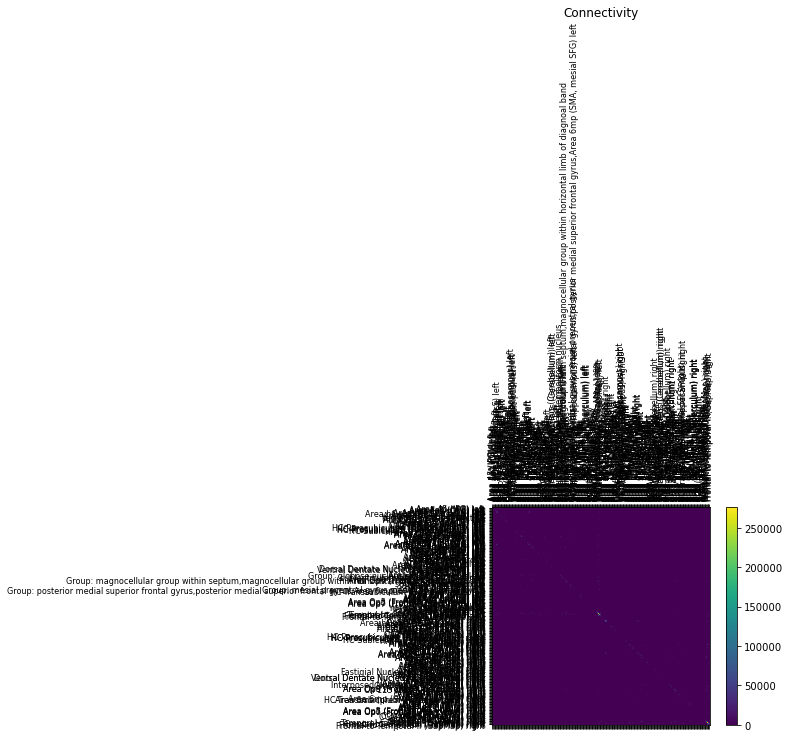

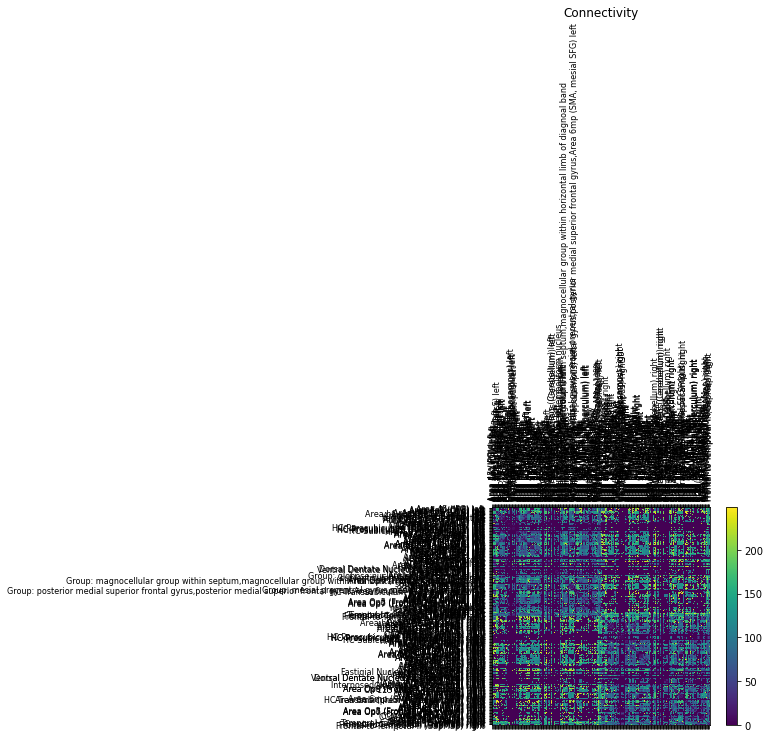

In [26]:
plot_connectivity(tvb_conn[1])

#### 2. For functional connectivities

In [ ]:
tvb_fcs = get_functional_connectivities_from_kg('human', '2.9', ['000'])
tvb_fcs